In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import glob, shutil, os

#------------------------------------

from torch.optim import Adam, AdamW

#------------------------------------

import poseigen_seaside.basics as se
import poseigen_seaside.metrics as mex

import poseigen_compass as co

import poseigen_binmeths as bm

import poseigen_trident.utils as tu

import poseigen_oyster as oys

#------------------------------------

import R3_xps_functions as xpfus

In [ ]:
data_path = "../data/R3/"
os.makedirs(data_path, exist_ok=True)

os.chdir(data_path)

In [ ]:
fin_bins = se.PickleLoad('fin_bins')
print(fin_bins)

divset = ['Train', 'Stop.', ' Eval', 'Test']

xpsfolder = se.NewFolder('xps_4')  #3 used epoch sampling with 0.5 as default.      

10


In [ ]:
RO_folder = se.NewFolder('RO')

ex_oys_folder = se.NewFolder(RO_folder + 'exact')
oys_iter = 11
pn_RO_exact = se.NewFolder(ex_oys_folder + 'RO_' + str(oys_iter))
pn_RO_exact_top = se.NewFolder(pn_RO_exact + 'Top' + str(0))
exact_ranked_can_dict = se.PickleLoad(pn_RO_exact + 'ranked_can_dict')

exact_dict = exact_ranked_can_dict[0]

#---------------------------------------------

nonex_oys_folder = se.NewFolder(RO_folder + 'nonexact')
ne_iter = 11
pn_RO_ne = se.NewFolder(nonex_oys_folder + 'RO_' + str(ne_iter))
pn_RO_ne_top = se.NewFolder(pn_RO_ne + 'Top' + str(0))
ne_ranked_can_dict = se.PickleLoad(pn_RO_ne + 'ranked_can_dict')

ne_dict = ne_ranked_can_dict[0]

#---------------------------------------------

allconfigs = {'Exact': exact_dict, 'non-Exact': ne_dict}

In [5]:
#oys.DualOyster(**{k:v for k,v in exact_dict.items() if k not in ['batchsize', 'learningrate']})

In [ ]:
yy1_split_transaug = se.PickleLoad('yy1_split_transaug')

yy1_max = se.PickleLoad('yy1_max')

tri_tpacks = se.PickleLoad('tri_tpacks')

d_x1, d_y_ms, d_s, d_b, d_x2 = tri_tpacks

d_s_rs = np.swapaxes(np.expand_dims(d_s, axis = -1), 1, -1)

In [ ]:
masterpseudo = 1e-10

RMS_mode = [mex.MeanExpo, {'expo': 2, 'root': True}]
RMS_mode_pyt = [mex.MeanExpo, {'expo': 2, 'root': True, 'pyt': True}]

bm_args_np = {'byaxis': 1, 'useweights': False, 'seperate': False, 
              'summarize_mode': RMS_mode}

bm_args_pyt = {'byaxis': 1, 'useweights': False, 'seperate': False, 
               'summarize_mode': RMS_mode_pyt, 'pyt': True}

#------------------------------------------------

deverr_args_base = {'expo': 1, 'root': False,                                                       #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                    'pseudo': masterpseudo,
                    'scalefactor': yy1_max}

MDE_mode_np = [mex.DeviaError, {**deverr_args_base, 'pyt': False}]
MDE_mode_pyt = [mex.DeviaError, {**deverr_args_base, 'pyt': True}]  

B_MDE_mode_np = [tu.BinnedLoss, {'metrics_mode': MDE_mode_np, **bm_args_np}]
B_MDE_mode_pyt = [tu.BinnedLoss, {'metrics_mode': MDE_mode_pyt, **bm_args_pyt}]

In [8]:
flipo = [[-2, -1], [-2, -1]]

modo = oys.DualOyster
duds_mode = [xpfus.Reset_DualOyster, {}]

TCR_repeats = 15

TT_base =  {
    'inps': [d_x1, d_x2], 'out': d_y_ms, 
    'out_std': d_s_rs, 'out_bind': d_b,
    'Split': yy1_split_transaug,   
    'EUS': None, 'obs_weight': None,                    #!@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

    'mod_init_mode': duds_mode, 'duds': TCR_repeats,
    
    'metrics_mode': B_MDE_mode_np, 'smallest': True,
    'opt': Adam, 'maxepochs': 100, 
    'patience': 8, 'pickup': True,
    'flips': flipo, 'indivflips': True}

TCS_base = {'trainer': tu.TridentTrainer, 
                 'smallest': None,
                 'get_predictions': True, 'pred_rewrite': False, 
                 'add_pred_args': {'batchsize': 512, 'flips': flipo, 'avg_flips': True},
                 'score_on': 1, 'score_only': False} ### SCORING ON THE EVAL SET, MAKING ONMLY PREDS FOR IT. 

TCR_base = {'Splits': None, 'repeats': TCR_repeats,
               'pickup': False, 'savemodels': True, 'returnmodel': True}

#--------------------------------------------------------------------------

es_args = {'out': d_y_ms, 'out_std': d_s_rs, 'out_bind': d_b,
            'split': yy1_split_transaug,
            'metrics_mode': B_MDE_mode_np, 
            'score_on': 1,
            'std_cutoff': None, 'ddof': 1, 'top': 3, 'smallest': True}

In [ ]:
xp1_trial = 3                   # FROM 2 
xp3_trial = 3                   # FROM 2
xp5_trial = 3                   # FROM 2
xp6_trial = 3                   # FROM 2


xp1_id, xp3_id, xp5_id, xp6_id = ['xp' + str(x) + '_' + str(y) 
                                  for x,y in zip([1, 3, 5, 6], 
                                                 [xp1_trial, xp3_trial, xp5_trial, 
                                                  xp6_trial])]

pn_xp1, pn_xp3, pn_xp5, pn_xp6 = [se.NewFolder(xpsfolder + ido) 
                                            for ido in [xp1_id, xp3_id, xp5_id, xp6_id]]


# xp1: BinLoss

In [10]:
pn_xp1 = se.NewFolder(xpsfolder + 'xp1' + '_' + str(xp1_trial))

xp1_variables = ['Loss Function']

lossos = ['MDE', 'RBM', 'Shuffled MDE']

xp1_combs = [[lo] for lo in lossos]

xp1_combs = [[ic, c] for ic,c in enumerate(xp1_combs)]
xp1_combs

[[0, ['MDE']], [1, ['RBM']], [2, ['Shuffled MDE']]]

In [12]:
# modo = oys.DualOyster
# duds_mode = [Reset_DualOyster, {}]

# for icof, (cof_name, cof) in enumerate(allconfigs.items()):

#     for icom, com in xp1_combs:

#         pn_t1 = se.NewFolder(pn_xp1 + str(icof))
#         pn_t2 = se.NewFolder(pn_t1 + str(icom))

#         los = com[0]

#         lmo, lbx = (B_MDE_mode_pyt, True) if los == 'RBM' else (MDE_mode_pyt, False)

#         xp1_TT_args = {
#                        'loss_mode': lmo, 'loss_bind': lbx, **TT_base}
        
#         if los == 'Shuffled MDE': 
#             DY, DZ = TT_base['out'], TT_base['out_std']
#             DY_shuffled, DZ_shuffled = co.shuffle_train_val_arrays(TT_base['Split'], DY, DZ, has_val=True)
#             xp1_TT_args.update({'out': DY_shuffled, 'out_std': DZ_shuffled})
#             print('SHUFFLED')

#         xp1_TCS_args = {'trainer_args': xp1_TT_args, **TCS_base}

#         xp1_TCR_args = {**xp1_TCS_args, **TCR_base, 'pathname': pn_t2}

#         _, _= tu.TridentCanRepeater(modo, cof, data = None, **xp1_TCR_args)

In [12]:
xp1_bs_all, xp1_bs_r2r_all = xpfus.XpsResults(pn_xp1, xp1_combs, 
                                              TCR_repeats, es_args, allconfigs,
                                              
                                              ref_ic = 0, rewrite = False)

---- Finished 0 ----
---- Finished 2 ----
---- Finished 1 ----
**** Finished 0 ****
---- Finished 0 ----
---- Finished 2 ----
---- Finished 1 ----
**** Finished 1 ****


In [13]:
xp1_tabs = xpfus.XpsTables(pn_xp1, xp1_combs, xp1_variables, xp1_bs_r2r_all, allconfigs)

xp1_tab_main, xp1_tab_main_sty, xp1_tab_extra, xp1_tab_extra_sty = xp1_tabs

xp1_tab_main_sty

(2, 3, 10000, 4)


,Exact,non-Exact
Loss Function,,
MDE,0.2,1.2
RBM,-54.7,-2.9
Shuffled MDE,322.5,592.6


In [14]:
xp1_tab_extra_sty

In [15]:
xpfus.save_styled_tables(xp1_tab_main_sty, xp1_tab_extra_sty, pn_xp1)

Saved styled tables as tables/xp1_3_tab_main_sty.xlsx and tables/xp1_3_tab_extra_sty.xlsx


# xp3 

In [ ]:
weighttypes = ['DW','RBW']

newrange = True
traino = yy1_split_transaug[0]
shx_args = {'onlyidx': traino, 'newrange': True}
mino = False #ONLY RECIP

yy1_weights = {} 

for wt in weighttypes:
    if wt == weighttypes[0]:
        yy1_weights[wt] = se.DenseWeighter(d_y_ms, alpha = 1.0, multi = False, 
                                        **shx_args)
    else: 
        yy1_weights[wt] = bm.BinWeighter(d_b,
                                      byaxis = None, uni = None, 
                                      minus = mino, dtype = np.float32, 
                                      **shx_args)
        
se. PickleDump(yy1_weights, 'yy1_weights')

yy1_weights = se.PickleLoad('yy1_weights')

# plt.scatter(*[x.reshape(-1)[::10] for x in [d_b, yy1_weights['RBW']]])

In [17]:
pn_xp3 = se.NewFolder(xpsfolder + 'xp3' + '_' + str(xp3_trial))

xp3_variables = ['Weighting']

binweis = ['None', 'DenseW', 'Recip.']
xp3_combs = []

for bw in binweis: xp3_combs.append([bw])

xp3_combs = [[ic, c] for ic,c in enumerate(xp3_combs)]
xp3_combs

[[0, ['None']], [1, ['DenseW']], [2, ['Recip.']]]

In [19]:
# xp3_rewrite = True

# lmo, lbx = MDE_mode_pyt, False
# modo = oys.DualOyster
# duds_mode = [Reset_DualOyster, {}]

# for icof, (cof_name, cof) in enumerate(allconfigs.items()):

#     for icom, com in xp3_combs:

#         pn_t1 = se.NewFolder(pn_xp3 + str(icof))
#         pn_t2 = se.NewFolder(pn_t1 + str(icom))

#         bw = com[0]

#         #---------------------------------------

#         par_xp, par_unit = None, None

#         if bw == 'None': par_xp, par_unit = xp1_id, 0

#         if par_unit is not None: 
#             XpsCopy(cur_pn = pn_t2, cur_xp_id = xp3_id, 
#                     past_xp_id = par_xp, past_unit = par_unit, 
#                     rewrite = xp3_rewrite)
        
#         #---------------------------------------
       
#         if bw != binweis[0]:
            
#             print('WEIGHTING')

#             if bw == binweis[1]: DW = yy1_weights[weighttypes[0]]
#             elif bw == binweis[2]: DW = yy1_weights[weighttypes[1]]
        
#         else: DW = None

#         #---------------------------------------
                

#         xp3_TT_args = {'out_weights': DW, 'loss_mode': lmo, 'loss_bind': lbx, **TT_base}

#         xp3_TCS_args = {'trainer_args': xp3_TT_args, **TCS_base}

#         xp3_TCR_args = {**xp3_TCS_args, **TCR_base, 'pathname': pn_t2}

#         _, _= tu.TridentCanRepeater(modo, cof, data = None, **xp3_TCR_args)

In [18]:
xp3_bs_all, xp3_bs_r2r_all = xpfus.XpsResults(pn_xp3, xp3_combs, 
                                              TCR_repeats, es_args, allconfigs,
                                              
                                              ref_ic = 0, rewrite = False)

---- Finished 1 -------- Finished 2 ----

---- Finished 0 ----
**** Finished 0 ****
---- Finished 2 ----
---- Finished 1 ----
---- Finished 0 ----
**** Finished 1 ****


In [19]:
xp3_tabs = xpfus.XpsTables(pn_xp3, xp3_combs, xp3_variables, xp3_bs_r2r_all, allconfigs)

xp3_tab_main, xp3_tab_main_sty, xp3_tab_extra, xp3_tab_extra_sty = xp3_tabs

xp3_tab_main_sty

(2, 3, 10000, 4)


,Exact,non-Exact
Weighting,,
None,0.2,1.2
DenseW,-20.7,-12.4
Recip.,-56.4,11.4


In [20]:
xp3_tab_extra_sty

In [21]:
xpfus.save_styled_tables(xp3_tab_main_sty, xp3_tab_extra_sty, pn_xp3)

Saved styled tables as tables/xp3_3_tab_main_sty.xlsx and tables/xp3_3_tab_extra_sty.xlsx


# xp5

In [22]:
us_props = ['None'] + [0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.01]
print(us_props)

['None', 0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.01]


In [23]:
pn_xp5 = se.NewFolder(xpsfolder + xp5_id)

xp5_variables = ['Samp. Prop.'] 

xp5_combs = []
for us in us_props: xp5_combs.append([us])
    
xp5_combs = [[ic, c] for ic,c in enumerate(xp5_combs)]
xp5_combs

[[0, ['None']],
 [1, [0.8]],
 [2, [0.4]],
 [3, [0.2]],
 [4, [0.1]],
 [5, [0.05]],
 [6, [0.025]],
 [7, [0.01]]]

In [ ]:
# xp5_rewrite = True

# lmo, lbx = MDE_mode_pyt, False

# for icof, (cof_name, cof) in enumerate(allconfigs.items()):

#     for icom, com in xp5_combs:

#         pn_t1 = se.NewFolder(pn_xp5 + str(icof))
#         pn_t2 = se.NewFolder(pn_t1 + str(icom))

#         us = com[0]

#         #---------------------------------------

#         par_xp, par_unit = None, None

#         if us == 'None': par_xp, par_unit = xp1_id, 0

#         if par_unit is not None: 
#             XpsCopy(cur_pn = pn_t2, cur_xp_id = xp5_id, 
#                     past_xp_id = par_xp, past_unit = par_unit, 
#                     rewrite = xp5_rewrite)
        
#         #--------------------------------------- 
        
#         if us == 'None': us = None           

#         xp5_TT_args = {'out_weights': None,  'loss_mode': lmo, 'loss_bind': lbx, **TT_base}
        
#         xp5_TT_args.update({'EUS': us, 'obs_weight': d_b.reshape(-1)})

#         xp5_TCS_args = {'trainer_args': xp5_TT_args, **TCS_base}

#         xp5_TCR_args = {**xp5_TCS_args, **TCR_base, 'pathname': pn_t2}

#         _, _= tu.TridentCanRepeater(modo, cof, data = None, **xp5_TCR_args)

In [24]:
xp5_bs_all, xp5_bs_r2r_all = xpfus.XpsResults(pn_xp5, xp5_combs, 
                                              TCR_repeats, es_args, allconfigs,
                                              
                                              ref_ic = 0, rewrite = False)

---- Finished 7 ----
---- Finished 6 ----
---- Finished 1 ----
---- Finished 3 ----
---- Finished 5 ----
---- Finished 4 ----
---- Finished 2 ----
---- Finished 0 ----
**** Finished 0 ****
---- Finished 1 ----
---- Finished 2 ----
---- Finished 4 ----
---- Finished 5 ----
---- Finished 7 ----
---- Finished 6 ----
---- Finished 0 ----
---- Finished 3 ----
**** Finished 1 ****


In [25]:
xp5_tabs = xpfus.XpsTables(pn_xp5, xp5_combs, xp5_variables, xp5_bs_r2r_all, allconfigs)

xp5_tab_main, xp5_tab_main_sty, xp5_tab_extra, xp5_tab_extra_sty = xp5_tabs

xp5_tab_main_sty

(2, 8, 10000, 4)


,Exact,non-Exact
Samp. Prop.,,
None,0.2,1.2
0.800000,-23.7,-8.4
0.400000,-29.7,3.6
0.200000,-39.2,-19.1
0.100000,-24.6,-24.4
0.050000,14.1,-25.2
0.025000,-38.5,-22.0
0.010000,-18.1,-14.0


In [26]:
xp5_tab_extra_sty

In [27]:
xpfus.save_styled_tables(xp5_tab_main_sty, xp5_tab_extra_sty, pn_xp5)

Saved styled tables as tables/xp5_3_tab_main_sty.xlsx and tables/xp5_3_tab_extra_sty.xlsx


# xp6: Combinations

In [28]:
pn_xp6 = se.NewFolder(xpsfolder + xp6_id)

xp6_variables = ['Loss Function', 'Weighting', 'Sampling']

top_lf = ['MDE', 'RBM']
top_weis = ['None', 'Recip.']
top_us = [False, True]

xp6_combs = []

for los in top_lf: 

    for bw in top_weis: 
        
        for us in top_us:
        
            xp6_combs.append([los, bw, us])

xp6_combs = [[ic, c] for ic,c in enumerate(xp6_combs)]
xp6_combs

[[0, ['MDE', 'None', False]],
 [1, ['MDE', 'None', True]],
 [2, ['MDE', 'Recip.', False]],
 [3, ['MDE', 'Recip.', True]],
 [4, ['RBM', 'None', False]],
 [5, ['RBM', 'None', True]],
 [6, ['RBM', 'Recip.', False]],
 [7, ['RBM', 'Recip.', True]]]

In [29]:
# xp6_rewrite = True

# lmo, lbx = MDE_mode_pyt, False

# best_eus = {0: 0.2, 1: 0.05}


# for icof, (cof_name, cof) in enumerate(allconfigs.items()):

#     for icom, com in xp6_combs:

#         pn_t1 = se.NewFolder(pn_xp6 + str(icof))
#         pn_t2 = se.NewFolder(pn_t1 + str(icom))

#         print(icof, icom)

#         los, bw, us = com

#         #---------------------------------------

#         par_xp, par_unit = None, None

#         if icom == 0: par_xp, par_unit = xp1_id, 0

#         if icom == 1: par_xp, par_unit = xp5_id, us_props.index(best_eus[icof])
            
#         if icom == 2: par_xp, par_unit = xp3_id, 2 # RECIP
#         if icom == 4: par_xp, par_unit = xp1_id, 1 # RBR

#         print(par_xp, par_unit)

#         if par_unit is not None: 
#             XpsCopy(cur_pn = pn_t2, cur_xp_id = xp6_id, 
#                     past_xp_id = par_xp, past_unit = par_unit, 
#                     rewrite = xp6_rewrite)
        
#         #---------------------------------------

#         lmo, lbx = (MDE_mode_pyt, False) if los == 'MDE' else (B_MDE_mode_pyt, True)

#         sampweimode = None 
#         if bw != top_weis[0]:
#             sampweimode = [bm.BinWeighter, {'uni': np.arange(fin_bins), 'byaxis': None, 
#                                             'minus': False, 'newrange': True}]

      
#         usxo = best_eus[icof] if us else None 
#         print(usxo)
        
#         #---------------------------------------
        
#         xp6_TT_args = {'loss_mode': lmo, 'loss_bind': lbx,
#                        'weights_mode': sampweimode, 'weights_bind': True,          
#                        **TT_base}
        
#         xp6_TT_args.update({'EUS': usxo, 'obs_weight': d_b.reshape(-1)})
        
#         xp6_TCS_args = {'trainer_args': xp6_TT_args, **TCS_base}

#         xp6_TCR_args = {**xp6_TCS_args, **TCR_base, 'pathname': pn_t2}

#         _, _= tu.TridentCanRepeater(modo, cof, data = None, **xp6_TCR_args)

In [30]:
xp6_bs_all, xp6_bs_r2r_all = xpfus.XpsResults(pn_xp6, xp6_combs, 
                                              TCR_repeats, es_args, allconfigs,
                                              
                                              ref_ic = 0, rewrite = False)

---- Finished 2 ----
---- Finished 6 ----
---- Finished 5 ----
---- Finished 4 ----
---- Finished 0 ----
---- Finished 7 ----
---- Finished 3 ----
---- Finished 1 ----
**** Finished 0 ****
---- Finished 7 ----
---- Finished 6 ----
---- Finished 0 ----
---- Finished 5 ----
---- Finished 3 ----
---- Finished 2 ----
---- Finished 1 ----
---- Finished 4 ----
**** Finished 1 ****


In [31]:
xp6_tabs = xpfus.XpsTables(pn_xp6, xp6_combs, xp6_variables, xp6_bs_r2r_all, allconfigs)

xp6_tab_main, xp6_tab_main_sty, xp6_tab_extra, xp6_tab_extra_sty = xp6_tabs

xp6_tab_main_sty

(2, 8, 10000, 4)


,Exact,non-Exact
Combination,,
"('MDE', 'None', False)",0.2,1.2
"('MDE', 'None', True)",-39.2,-25.2
"('MDE', 'Recip.', False)",-56.4,11.4
"('MDE', 'Recip.', True)",-56.2,-29.3
"('RBM', 'None', False)",-54.7,-2.9
"('RBM', 'None', True)",-55.8,-32.4
"('RBM', 'Recip.', False)",-47.3,57.8
"('RBM', 'Recip.', True)",-57.7,-28.8


In [32]:
xp6_tab_extra_sty

In [33]:
xpfus.save_styled_tables(xp6_tab_main_sty, xp6_tab_extra_sty, pn_xp6)

Saved styled tables as tables/xp6_3_tab_main_sty.xlsx and tables/xp6_3_tab_extra_sty.xlsx


### Comparing Configs

In [34]:
def CompareConfigs_Scores(xp_bse, ref = 0):

    #compares configs by scores array of (configs, xp units, scores, sets)
    #compares configs to a reference config 

    pf_args = {'mode1': [se.RelativeChange, {'perc': True}]}

    boots_rel2ref = [[se.PairwiseFuncer(co, c[ref], **pf_args) for co in c] 
                     for c in np.swapaxes(xp_bse, 0, 1)]
    
    return np.swapaxes(np.array(boots_rel2ref), 0, 1)


xp6_cc = CompareConfigs_Scores(xp6_bs_all)

cc_tab_main, cc_tab_main_sty, cc_tab_extra_main, cc_tab_extra_main_sty = xpfus.XpsTables(pn_xp6, xp6_combs, xp6_variables, xp6_cc, allconfigs)

# cc_tab_main_sty

(2, 8, 10000, 4)


In [35]:
bests = list(xp6_tab_main.apply(np.argmin, axis=0))
print(bests)


xp6_bse_bests = np.stack([co[b] for co, b in zip(xp6_bs_all, bests)])

xp6_snb = np.stack([xp6_bse_bests], axis = 1) #np.stack([xp6_bse_stands, xp6_bse_bests], axis = 1)

snb_combs = [[n, [x]] for n, x in enumerate(['Best'])] # ['Standard', 'Best']
snb_variables = ['Method']

xp6_snb_cc = CompareConfigs_Scores(xp6_snb)

snb_tab_main, snb_tab_main_sty, snb_tab_extra, snb_tab_extra_sty = xpfus.XpsTables(pn_xp6, snb_combs, snb_variables, xp6_snb_cc, allconfigs)

snb_tab_main_sty

[7, 5]
(2, 1, 10000, 4)


,Exact,non-Exact
Method,,
Best,0.2,-1.9


In [36]:
snb_tab_extra_sty

In [37]:
xpfus.save_styled_tables(snb_tab_main_sty, snb_tab_extra_sty, pn_xp6, prefix_ext='snb')

Saved styled tables as tables/xp6_3_snb_tab_main_sty.xlsx and tables/xp6_3_snb_tab_extra_sty.xlsx


## Final Performance

In [23]:
pn_xpF, icof, icom = pn_xp6, 0, bests[0]

pn_t1 = se.NewFolder(pn_xpF + str(icof))
pn_t2 = se.NewFolder(pn_t1 + str(icom))

ex_pn_preds = [pn_t2 + '0_' + str(ir) + '_Preds.p' 
                  for ir in range(TCR_repeats)]

#-----------------------------------------------------

_ = co.EnsembleScorer(ex_pn_preds, **es_args,
                   pathname = pn_t2, return_extra = False)

ex_ens_idx = se.PickleLoad(pn_t2 + 'ensemble_idx')
print(ex_ens_idx)

ex_ens_pn_preds = [pn_t2 + '0_' + str(ir) + '_Preds.p' for ir in ex_ens_idx] 
ex_ens_preds = np.stack([se.PickleLoad(p) for p in ex_ens_pn_preds]).mean(0)

[5 7 9]


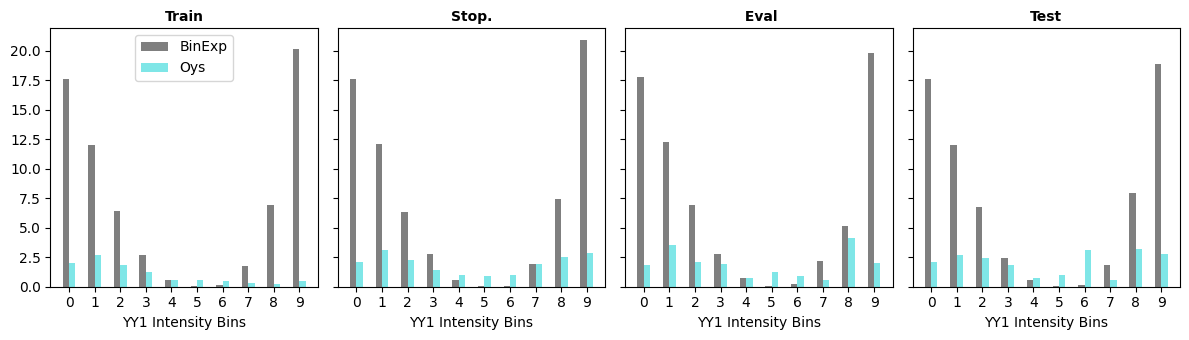

In [24]:
divset = ['Train', 'Stop.', ' Eval', 'Test']

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

#----------------------------------------------------

splix = yy1_split_transaug[0]

d_y_ms_bind = [d_y_ms[splix][d_b[splix] == i] for i in np.arange(fin_bins)]
d_y_ms_bind_mean = [np.mean(d, keepdims= True) for d in d_y_ms_bind]
d_y_ms_mom = np.mean(d_y_ms_bind_mean)
d_y_ms_mom_xpa = np.repeat(d_y_ms_mom, d_y_ms.shape[0]).reshape(d_y_ms.shape)

#--------------------------------------------------------


BM_args = {'metrics_mode': MDE_mode_np, 'summarize_mode': None}

mom_BM = np.array([tu.BinnedLoss(d_y_ms_mom_xpa[O], d_y_ms[O],
                        std = d_s_rs[O], bind = d_b[O].reshape(-1),
                        **BM_args) for O in yy1_split_transaug])

ex_ens_BM = np.array([tu.BinnedLoss(ex_ens_preds[O], d_y_ms[O],
                        std = d_s_rs[O], bind = d_b[O].reshape(-1),
                        **BM_args) for O in yy1_split_transaug])


comb_BM = np.concatenate([mom_BM, ex_ens_BM], axis = 1) 

comb_BM_red = [[np.arange(fin_bins), comb_BM[io]] for io in np.arange(len(yy1_split_transaug))]

bp_args = {'xlabel': 'YY1 Intensity Bins',
            'labelheight': False, 'alpha': 0.5, 
            'group': ['BinExp', 'Oys', 'Bas'], 'color': ['black', 'darkturquoise'], 
            'width': 0.25}

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

viz.MultiPlot(comb_BM_red, **mp_args,  
          plt_mode = [viz.BarPlot, bp_args], 
          indiv_args = {'legend': [True, False, False, False]});

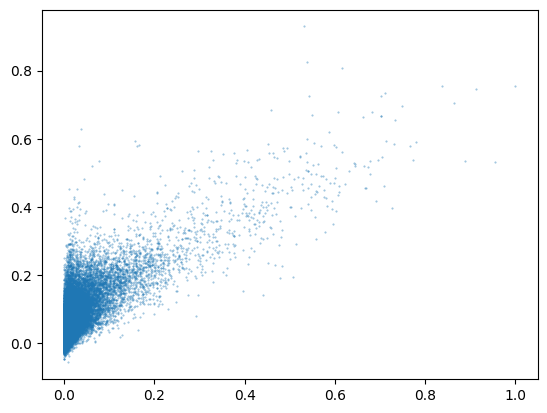

In [25]:
plt.scatter(*[x.reshape(-1) for x in [d_y_ms, ex_ens_preds]], s = 0.2, alpha = 0.5)